In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import random


In [2]:
!pip3 install matplotlib



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


## Part 1: Using the Spectrogram Image to classify the Music


### Data Prepocessing

class_to_idx: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
class_names: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Total samples: 999
Unique labels: [0 1 2 3 4 5 6 7 8 9]

Dataset split - Train: 799, Val: 99, Test: 101


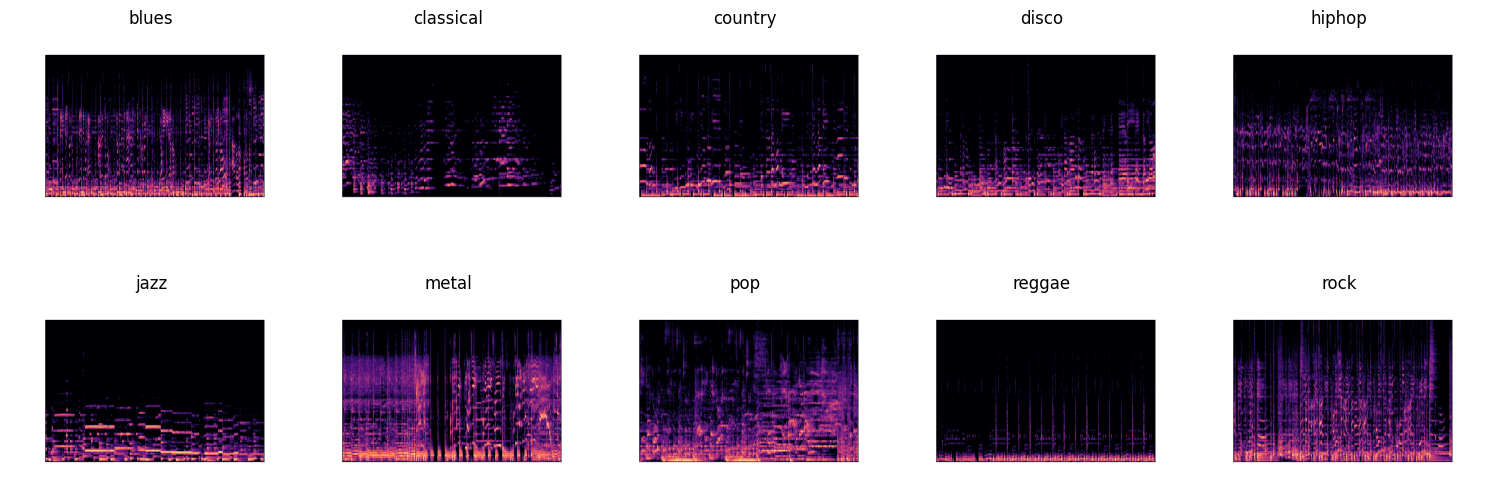

In [3]:

root_dir = "./images_original"
img_size = 128
batch_size = 32

# Get class names
class_names = sorted([
    d for d in os.listdir(root_dir)
    if os.path.isdir(os.path.join(root_dir, d)) and not d.startswith(".")
])
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

print("class_to_idx:", class_to_idx)
print("class_names:", class_names)

# Collect file paths and labels
filepaths = []
labels = []

for genre in class_names:
    genre_folder = os.path.join(root_dir, genre)
    for fname in os.listdir(genre_folder):
        if fname.lower().endswith(".png"):
            filepaths.append(os.path.join(genre_folder, fname))
            labels.append(class_to_idx[genre])

filepaths = np.array(filepaths)
labels = np.array(labels, dtype=np.int32)

print("Total samples:", len(filepaths))
print("Unique labels:", np.unique(labels))

# Preprocessing function
def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

# Create train/val/test splits
dataset_size = len(filepaths)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)

ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
ds = ds.shuffle(dataset_size, seed=42, reshuffle_each_iteration=False)

train_ds = ds.take(train_size)
rest_ds = ds.skip(train_size)
val_ds = rest_ds.take(val_size)
test_ds = rest_ds.skip(val_size)

# Apply preprocessing and batching
train_ds = train_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print(f"\nDataset split - Train: {train_size}, Val: {val_size}, Test: {dataset_size - train_size - val_size}")

# Collect one sample from each genre
sample_images = {}
for genre in class_names:
    genre_folder = os.path.join(root_dir, genre)
    genre_files = [f for f in os.listdir(genre_folder) if f.lower().endswith(".png")]
    if genre_files:
        sample_path = os.path.join(genre_folder, random.choice(genre_files))
        sample_images[genre] = Image.open(sample_path)

# Display samples
n_classes = len(class_names)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, genre in enumerate(class_names):
    if genre in sample_images:
        axes[i].imshow(sample_images[genre])
        axes[i].set_title(genre)
        axes[i].axis('off')

plt.tight_layout()
plt.show()


### Model Training

In [4]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras import layers, models, Input


In [5]:
from tensorflow.keras import layers, models

def build_cnn(input_shape=(128, 128, 3), num_classes=10):
    """
    Build a simple CNN model for spectrogram classification
    """
    model = models.Sequential([
        # Conv Block 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Conv Block 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Conv Block 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Conv Block 4
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Fully connected layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ], name='CNN_Spectrogram')
    
    return model

# Build and compile CNN model
cnn_model = build_cnn(input_shape=(128, 128, 3), num_classes=len(class_names))

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("="*50)
print("CNN Model Summary")
print("="*50)
cnn_model.summary()

CNN Model Summary


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "CNN_Spectrogram"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,243,338 (20.00 MB)

 Trainable params: 5,242,378 (20.00 MB)

 Non-trainable params: 960 (3.75 KB)

In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, Input


def build_resnet50(input_shape=(128, 128, 3), num_classes=10):
    """
    Build ResNet50 transfer learning model for spectrogram classification
    """
    inputs = Input(shape=input_shape)
    
    # Load ResNet50 with ImageNet weights
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_tensor=inputs
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Add classification head
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs, name='ResNet50_Transfer')
    
    return model

# Build and compile ResNet50 model
resnet_model = build_resnet50(input_shape=(128, 128, 3), num_classes=len(class_names))

resnet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("="*50)
print("ResNet50 Model Summary")
print("="*50)
resnet_model.summary()

ResNet50 Model Summary


Model: "ResNet50_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 24,770,698 (94.49 MB)

 Trainable params: 1,182,986 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, Input



def build_vgg16(input_shape=(128, 128, 3), num_classes=10):
    """
    Build VGG16 transfer learning model for spectrogram classification
    """
    inputs = Input(shape=input_shape)
    
    # Load VGG16 with ImageNet weights
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_tensor=inputs
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Add classification head
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs, name='VGG16_Transfer')
    
    return model

# Build and compile VGG16 model
vgg_model = build_vgg16(input_shape=(128, 128, 3), num_classes=len(class_names))

vgg_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("="*50)
print("VGG16 Model Summary")
print("="*50)
vgg_model.summary()

VGG16 Model Summary


Model: "VGG16_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         2,57

 Total params: 19,043,402 (72.64 MB)

 Trainable params: 4,328,714 (16.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
from tensorflow import keras


def train_model(model, train_data, val_data, model_name, epochs=50, patience=5):

    # Early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )
    
    # Reduce learning rate on plateau
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
    
    # Save best model
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath=f"{model_name.replace(' ', '_')}_best.keras",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    print(f"Training {model_name} ...")
    
    # Train the model
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr, checkpoint],
        verbose=1
    )
    
    return history, model

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np



def evaluate_model(model, test_data, model_name):
    """
    Evaluate trained model on the test set
    
    Args:
        model: Trained Keras model
        test_data: Test dataset
        model_name: Name of the model
    
    Returns:
        Dictionary with accuracy, loss, precision, recall, F1 score
    """
    
    print("\n" + "="*80)
    print(f"Evaluating {model_name}")
    print("="*80)
    
    # Evaluate loss & accuracy
    loss, accuracy = model.evaluate(test_data, verbose=1)
    
    # Collect predictions
    y_true = []
    y_pred = []
    
    for images, labels in test_data:
        preds = model.predict(images, verbose=0)
        preds = np.argmax(preds, axis=1)
        
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
    
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Multi-class metrics
    precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recall = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    
    print(f"\nResults for {model_name}:")
    print(f"  Loss:      {loss:.4f}")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    
    return {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

In [10]:


history_cnn, trained_cnn = train_model(
    cnn_model,
    train_ds,
    val_ds,
    model_name="CNN_Spectrogram",
    epochs=50,
    patience=5
)

cnn_results = evaluate_model(trained_cnn, test_ds, "CNN_Spectrogram")

Training CNN_Spectrogram ...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.1532 - loss: 6.1843
Epoch 1: val_accuracy improved from -inf to 0.13131, saving model to CNN_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.1538 - loss: 6.1320 - val_accuracy: 0.1313 - val_loss: 2.7775 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.1926 - loss: 2.5290
Epoch 2: val_accuracy did not improve from 0.13131
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.1925 - loss: 2.5216 - val_accuracy: 0.1313 - val_loss: 7.2905 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.1652 - loss: 2.1910
Epoch 3: val_accuracy did not improve from 0.13131
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.1661 - loss: 2.1898 - val_accuracy: 0.1313 - val_loss: 13.6573 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.2097 - loss: 2.1480
Epoch

In [11]:
history_resnet, trained_resnet = train_model(
    resnet_model,
    train_ds,
    val_ds,
    model_name="ResNet50_Spectrogram",
    epochs=50,
    patience=5
)
resnet_results = evaluate_model(trained_resnet, test_ds, "ResNet50_Spectrogram")

Training ResNet50_Spectrogram ...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.0994 - loss: 2.4747
Epoch 1: val_accuracy improved from -inf to 0.06061, saving model to ResNet50_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.0992 - loss: 2.4727 - val_accuracy: 0.0606 - val_loss: 2.3344 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.1140 - loss: 2.3813
Epoch 2: val_accuracy improved from 0.06061 to 0.12121, saving model to ResNet50_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.1142 - loss: 2.3802 - val_accuracy: 0.1212 - val_loss: 2.2902 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.0806 - loss: 2.3409
Epoch 3: val_accuracy did not improve from 0.12121
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.0805 - loss: 2.3406 - val_accuracy: 0.0606 - val_loss: 2.3009 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━

In [12]:

history_vgg, trained_vgg = train_model(
    vgg_model,
    train_ds,
    val_ds,
    model_name="VGG16_Spectrogram",
    epochs=50,
    patience=5
)

vgg_results = evaluate_model(trained_vgg, test_ds, "VGG16_Spectrogram")


Training VGG16_Spectrogram ...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.1174 - loss: 2.7732
Epoch 1: val_accuracy improved from -inf to 0.23232, saving model to VGG16_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 644ms/step - accuracy: 0.1177 - loss: 2.7659 - val_accuracy: 0.2323 - val_loss: 2.1953 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.1785 - loss: 2.2157
Epoch 2: val_accuracy improved from 0.23232 to 0.29293, saving model to VGG16_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 633ms/step - accuracy: 0.1794 - loss: 2.2139 - val_accuracy: 0.2929 - val_loss: 1.9736 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.2614 - loss: 2.0259
Epoch 3: val_accuracy improved from 0.29293 to 0.38384, saving model to VGG16_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 636ms/step - accuracy: 0.2619 - loss: 2.0255 - val_accuracy: 0.3838 - val_loss: 1.8604 - learnin

In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models, Input
import tensorflow as tf

# ===========================
# RESNET50 MODEL WITH CORRECT PREPROCESSING
# ===========================

def build_resnet50(input_shape=(128, 128, 3), num_classes=10):
    """
    Build ResNet50 transfer learning model for spectrogram classification
    """
    inputs = Input(shape=input_shape)
    
    # Load ResNet50 with ImageNet weights
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_tensor=inputs
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Add classification head
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs, name='ResNet50_Transfer')
    
    return model

# Preprocessing function for ResNet50
def load_and_preprocess_resnet(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = preprocess_input(img)  # ResNet50 specific preprocessing
    return img, label

# Rebuild dataset with correct preprocessing
ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
ds = ds.shuffle(dataset_size, seed=42, reshuffle_each_iteration=False)

train_ds_resnet = ds.take(train_size)
rest_ds = ds.skip(train_size)
val_ds_resnet = rest_ds.take(val_size)
test_ds_resnet = rest_ds.skip(val_size)

train_ds_resnet = train_ds_resnet.map(load_and_preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_resnet = train_ds_resnet.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds_resnet = val_ds_resnet.map(load_and_preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_resnet = val_ds_resnet.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds_resnet = test_ds_resnet.map(load_and_preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_resnet = test_ds_resnet.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Build and compile ResNet50 model
resnet_model = build_resnet50(input_shape=(128, 128, 3), num_classes=len(class_names))

resnet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("="*50)
print("ResNet50 Model Summary")
print("="*50)
resnet_model.summary()

# Train ResNet50 model
history_resnet, trained_resnet = train_model(
    resnet_model,
    train_ds_resnet,
    val_ds_resnet,
    model_name="ResNet50_Spectrogram",
    epochs=50,
    patience=5
)

# Evaluate ResNet50 model
resnet_results = evaluate_model(trained_resnet, test_ds_resnet, "ResNet50_Spectrogram")

ResNet50 Model Summary


Model: "ResNet50_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 24,770,698 (94.49 MB)

 Trainable params: 1,182,986 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Training ResNet50_Spectrogram ...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.1759 - loss: 2.8925
Epoch 1: val_accuracy improved from -inf to 0.44444, saving model to ResNet50_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 256ms/step - accuracy: 0.1772 - loss: 2.8783 - val_accuracy: 0.4444 - val_loss: 1.6658 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.3307 - loss: 1.9124
Epoch 2: val_accuracy improved from 0.44444 to 0.48485, saving model to ResNet50_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.3308 - loss: 1.9103 - val_accuracy: 0.4848 - val_loss: 1.5559 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.3865 - loss: 1.7032
Epoch 3: val_accuracy improved from 0.48485 to 0.52525, saving model to ResNet50_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - accuracy: 0.3872 - loss: 1.7028 - val_accuracy: 0.5253 - val_loss: 1.4187 

In [14]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficient_preprocess
from tensorflow.keras import layers, models, Input
import tensorflow as tf


def build_efficientnet(input_shape=(128, 128, 3), num_classes=10):
    """
    Build EfficientNetB0 transfer learning model for spectrogram classification
    """
    inputs = Input(shape=input_shape)
    
    # Load EfficientNetB0 with ImageNet weights
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_tensor=inputs
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Add classification head
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs, name='EfficientNetB0_Transfer')
    
    return model

# Preprocessing function for EfficientNet
def load_and_preprocess_efficientnet(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = efficient_preprocess(img)  # EfficientNet specific preprocessing
    return img, label

# Rebuild dataset with correct preprocessing
ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
ds = ds.shuffle(dataset_size, seed=42, reshuffle_each_iteration=False)

train_ds_efficient = ds.take(train_size)
rest_ds = ds.skip(train_size)
val_ds_efficient = rest_ds.take(val_size)
test_ds_efficient = rest_ds.skip(val_size)

train_ds_efficient = train_ds_efficient.map(load_and_preprocess_efficientnet, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_efficient = train_ds_efficient.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds_efficient = val_ds_efficient.map(load_and_preprocess_efficientnet, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_efficient = val_ds_efficient.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds_efficient = test_ds_efficient.map(load_and_preprocess_efficientnet, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_efficient = test_ds_efficient.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Build and compile EfficientNet model
efficient_model = build_efficientnet(input_shape=(128, 128, 3), num_classes=len(class_names))

efficient_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("="*50)
print("EfficientNetB0 Model Summary")
print("="*50)
efficient_model.summary()

# Train EfficientNet model
history_efficient, trained_efficient = train_model(
    efficient_model,
    train_ds_efficient,
    val_ds_efficient,
    model_name="EfficientNetB0_Spectrogram",
    epochs=50,
    patience=5
)

# Evaluate EfficientNet model
efficient_results = evaluate_model(trained_efficient, test_ds_efficient, "EfficientNetB0_Spectrogram")

EfficientNetB0 Model Summary


Model: "EfficientNetB0_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 4,839,341 (18.46 MB)

 Trainable params: 789,770 (3.01 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Training EfficientNetB0_Spectrogram ...
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.1638 - loss: 2.2906
Epoch 1: val_accuracy improved from -inf to 0.31313, saving model to EfficientNetB0_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.1660 - loss: 2.2859 - val_accuracy: 0.3131 - val_loss: 1.7894 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3292 - loss: 1.8550
Epoch 2: val_accuracy improved from 0.31313 to 0.42424, saving model to EfficientNetB0_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.3293 - loss: 1.8550 - val_accuracy: 0.4242 - val_loss: 1.5625 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3748 - loss: 1.6946
Epoch 3: val_accuracy improved from 0.42424 to 0.47475, saving model to EfficientNetB0_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.3754 - loss: 1.6945 - val_accuracy: 0.474

## Part 2: Using feature data of the music (feature_3_sec.csv) to classify the music

### Data Prepocessing

In [15]:
import pandas as pd

df = pd.read_csv("features_3_sec.csv")   # or features_30_sec.csv
print(df.shape)
df.head()


(9990, 60)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [16]:
# labeling
labels = df["label"].values
label_to_idx = {name: i for i, name in enumerate(sorted(df["label"].unique()))}
idx_to_label = {v: k for k, v in label_to_idx.items()}
y = df["label"].map(label_to_idx).values
df["label_idx"] = y
print(label_to_idx)


{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


In [17]:
drop_cols = ["filename", "label"]
X = df.drop(columns=drop_cols).values   # shape: (N, 58 或 60)
y = df["label_idx"].values

In [18]:
!pip3 install seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


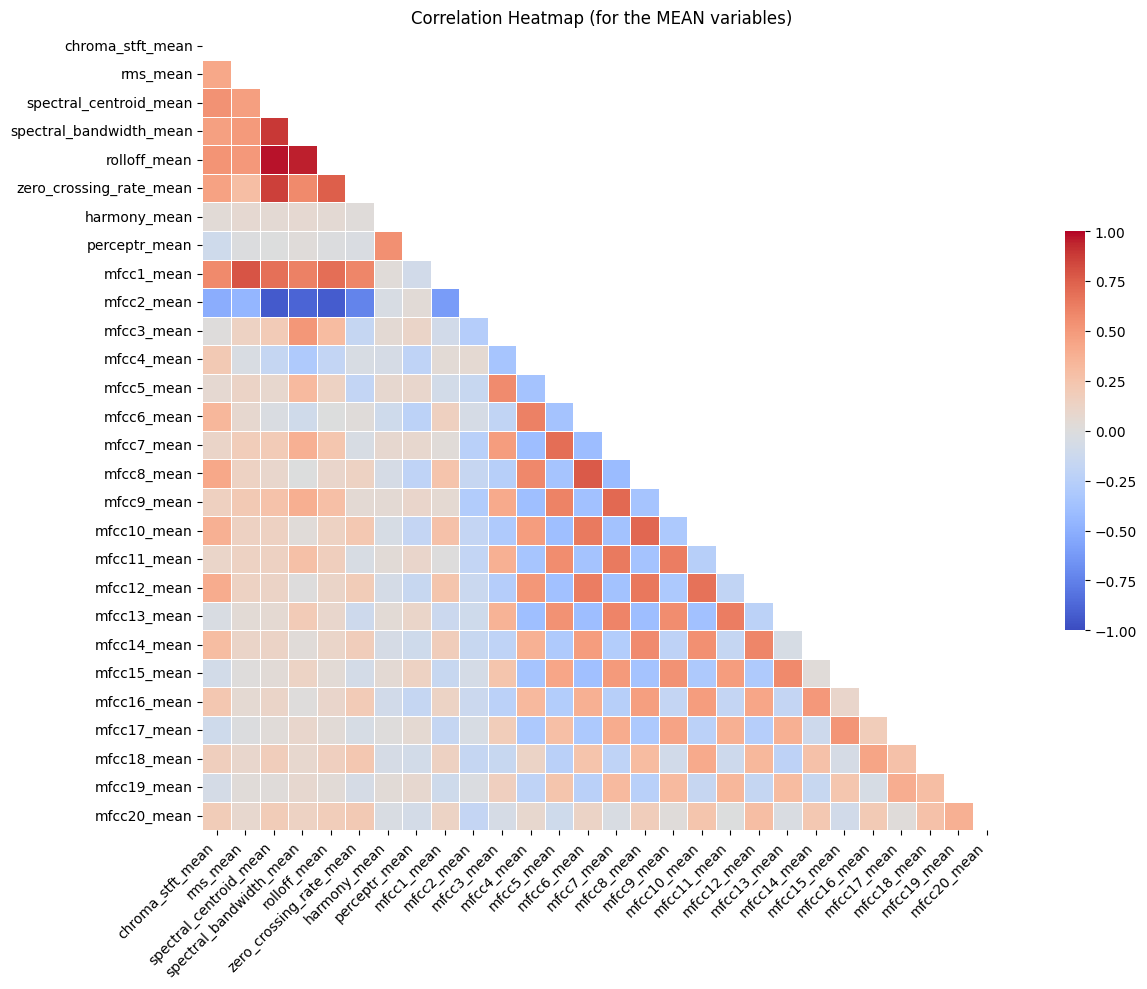

In [19]:

import seaborn as sns


mean_cols = [col for col in df.columns 
             if "mean" in col and col not in ["filename", "label"]]

df_means = df[mean_cols]

corr = df_means.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))   

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr,
    mask=mask,          
    cmap="coolwarm",    
    vmin=-1, vmax=1,   
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": .5}
)
plt.title("Correlation Heatmap (for the MEAN variables)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [20]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# X_train, X_temp, y_train, y_temp = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

# X_val, X_test, y_val, y_test = train_test_split(
#     X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
# )

# print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled   = scaler.transform(X_val)
# X_test_scaled  = scaler.transform(X_test)

In [21]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np

# 0. Load Data
df = pd.read_csv("features_3_sec.csv")

# 1. Create Song ID Groups
df['song_id'] = df['filename'].apply(lambda x: '.'.join(x.split('.')[:2]))
groups = df['song_id']

# 2. Encode Labels
le = LabelEncoder()
y = le.fit_transform(df['label'])

# 3. Prepare X
X = df.drop(columns=['filename', 'label', 'song_id']).values

# --- STAGE 1: Split into Train (80%) and Temp (20%) ---
splitter_1 = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idxs, temp_idxs = next(splitter_1.split(X, y, groups=groups))

X_train = X[train_idxs]
y_train = y[train_idxs]
groups_train = groups.iloc[train_idxs] # Not strictly needed but good for checking

X_temp = X[temp_idxs]
y_temp = y[temp_idxs]
groups_temp = groups.iloc[temp_idxs]   # Need this for the second split

# --- STAGE 2: Split Temp into Val (50% of Temp) and Test (50% of Temp) ---
# This results in 10% Val and 10% Test overall
splitter_2 = GroupShuffleSplit(test_size=0.5, n_splits=1, random_state=42)
val_idxs, test_idxs = next(splitter_2.split(X_temp, y_temp, groups=groups_temp))

X_val = X_temp[val_idxs]
y_val = y_temp[val_idxs]

X_test = X_temp[test_idxs]
y_test = y_temp[test_idxs]

# 4. Scale Data
# Fit scaler ONLY on training data to avoid information leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# 5. Verify
print(f"Data Split Successfully with Groups!")
print(f"Train Shape: {X_train.shape} (80%)")
print(f"Val Shape:   {X_val.shape}   (10%)")
print(f"Test Shape:  {X_test.shape}  (10%)")

Data Split Successfully with Groups!
Train Shape: (7993, 58) (80%)
Val Shape:   (998, 58)   (10%)
Test Shape:  (999, 58)  (10%)


### Model training

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# define the neighbors
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 15, 21],
    "weights": ["uniform", "distance"],
    "metric": ["minkowski", "manhattan", "cosine"],
    "p": [1, 2]  # only used for minkowski
}

# build the model
knn = KNeighborsClassifier()

# GridSearchCV
grid = GridSearchCV(
    knn,
    param_grid,
    cv=5,                  # 5-fold cross validation
    scoring="accuracy",
    n_jobs=-1,             
    verbose=1
)

grid.fit(X_train_scaled, y_train)

# best parameter
print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)


Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best Parameters: {'metric': 'minkowski', 'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
Best CV Accuracy: 0.5469754641707387


In [23]:
best_knn = grid.best_estimator_

# testing
test_acc = best_knn.score(X_test_scaled, y_test)
print("Test Accuracy:", test_acc)


Test Accuracy: 0.6736736736736737


In [24]:
from sklearn.metrics import classification_report

y_pred = best_knn.predict(X_test_scaled)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.69      0.60      0.64       100
           1       0.83      0.96      0.89        70
           2       0.63      0.66      0.65       110
           3       0.57      0.58      0.58       130
           4       0.48      0.72      0.58        69
           5       0.86      0.86      0.86       110
           6       0.86      0.82      0.84       160
           7       0.75      0.68      0.71        40
           8       0.63      0.50      0.56       120
           9       0.40      0.37      0.38        90

    accuracy                           0.67       999
   macro avg       0.67      0.68      0.67       999
weighted avg       0.68      0.67      0.67       999



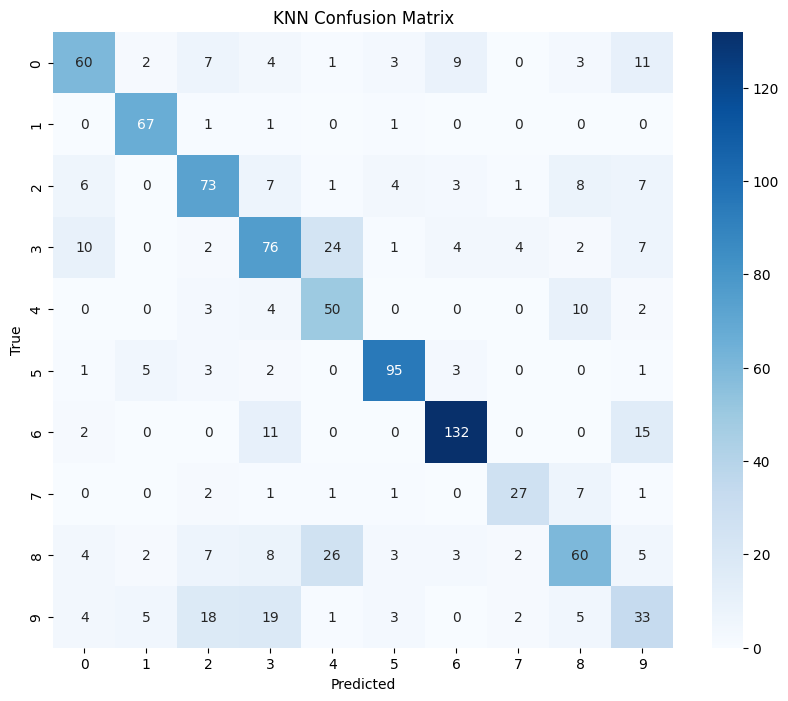

In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("KNN Confusion Matrix")
plt.show()


In [26]:
import tensorflow as tf
from tensorflow import keras as k


input_dim = X_train_scaled.shape[1]


num_classes = len(np.unique(y_train))

def build_mlp(input_dim, num_classes):
    model = k.models.Sequential([
        k.layers.Input(shape=(input_dim,)),
        k.layers.Dense(256, activation='relu'),
        k.layers.Dropout(0.4),
        k.layers.Dense(128, activation='relu'),
        k.layers.Dropout(0.3),
        k.layers.Dense(64, activation='relu'),
        k.layers.Dense(num_classes, activation='softmax')
    ])
    return model

model_mlp = build_mlp(input_dim, num_classes)
model_mlp.summary()

model_mlp.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)

callbacks = [
    k.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True
    )
]

history_mlp = model_mlp.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=80,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 256)            │        15,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,906 (222.29 KB)

 Trainable params: 56,906 (222.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3301 - loss: 1.8547 - val_accuracy: 0.5010 - val_loss: 1.3562
Epoch 2/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.5940 - loss: 1.1255 - val_accuracy: 0.5832 - val_loss: 1.1816
Epoch 3/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.6549 - loss: 0.9762 - val_accuracy: 0.6212 - val_loss: 1.1221
Epoch 4/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.6962 - loss: 0.8821 - val_accuracy: 0.6333 - val_loss: 1.0718
Epoch 5/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.7306 - loss: 0.7697 - val_accuracy: 0.6393 - val_loss: 1.0570
Epoch 6/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.7578 - loss: 0.6998 - val_accuracy: 0.6543 - val_loss: 1.0383
Epoch 7/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.7745 - loss: 0.6542 - val_accuracy: 0.6703 - val_loss: 1.0676
Epoch 8/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.7801 - loss: 0.6306 - va

MLP Test Accuracy: 0.7157157063484192
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step

MLP Classification Report (Test):
               precision    recall  f1-score   support

           0       0.67      0.74      0.70       100
           1       0.81      0.99      0.89        70
           2       0.73      0.75      0.74       110
           3       0.68      0.62      0.65       130
           4       0.52      0.72      0.61        69
           5       0.88      0.85      0.87       110
           6       0.85      0.84      0.85       160
           7       0.57      0.80      0.67        40
           8       0.68      0.39      0.50       120
           9       0.59      0.57      0.58        90

    accuracy                           0.72       999
   macro avg       0.70      0.73      0.70       999
weighted avg       0.72      0.72      0.71       999



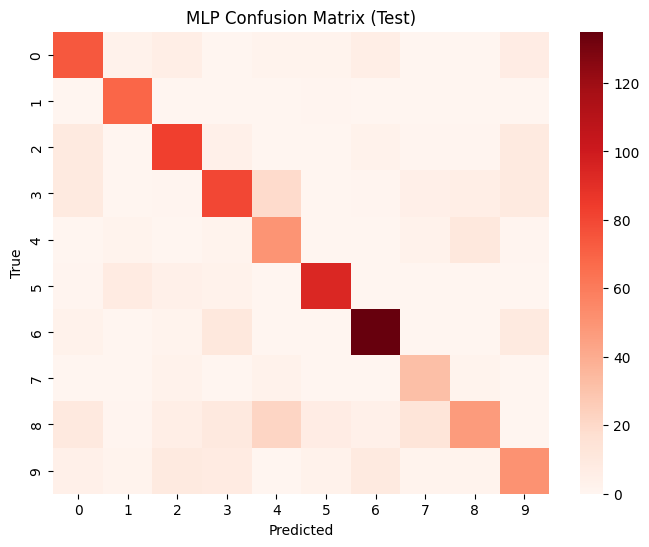

In [27]:
test_loss, test_acc = model_mlp.evaluate(X_test_scaled, y_test, verbose=0)
print("MLP Test Accuracy:", test_acc)

y_test_pred_mlp = model_mlp.predict(X_test_scaled).argmax(axis=1)
print("\nMLP Classification Report (Test):\n",
      classification_report(y_test, y_test_pred_mlp))

cm_mlp = confusion_matrix(y_test, y_test_pred_mlp)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mlp, cmap="Reds", annot=False)
plt.title("MLP Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Training Samples: 7993
Test Samples: 1997

Training XGBoost on clean split...

XGBoost Accuracy: 0.6960
              precision    recall  f1-score   support

       blues       0.60      0.70      0.65       200
   classical       0.92      0.96      0.94       130
     country       0.70      0.64      0.67       270
       disco       0.58      0.66      0.62       209
      hiphop       0.55      0.68      0.61       149
        jazz       0.88      0.87      0.87       220
       metal       0.82      0.90      0.86       250
         pop       0.71      0.65      0.68       130
      reggae       0.70      0.50      0.58       230
        rock       0.53      0.46      0.50       209

    accuracy                           0.70      1997
   macro avg       0.70      0.70      0.70      1997
weighted avg       0.70      0.70      0.69      1997



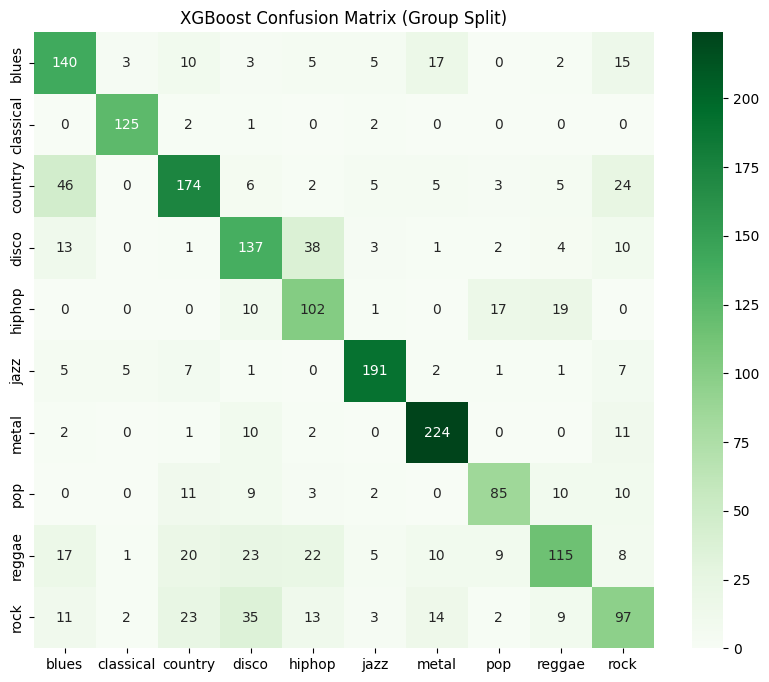

In [28]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
df = pd.read_csv("features_3_sec.csv")

# 2. Extract 'Song ID' to prevent leakage
# "blues.00000.0.wav" -> "blues.00000"
# This groups all 10 chunks of the same song together
df['song_id'] = df['filename'].apply(lambda x: '.'.join(x.split('.')[:2]))

# 3. Prepare Features (X) and Target (y)
X = df.drop(columns=['filename', 'label', 'song_id'])
y = df['label']
groups = df['song_id'] # This is what we split by

# 4. Encoding & Scaling
le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. The FIX: Split by GROUPS, not by random rows
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idxs, test_idxs = next(splitter.split(X, y, groups=groups))

X_train_clean = X_scaled[train_idxs]
X_test_clean = X_scaled[test_idxs]
y_train_clean = y_encoded[train_idxs]
y_test_clean = y_encoded[test_idxs]

print(f"Training Samples: {X_train_clean.shape[0]}")
print(f"Test Samples: {X_test_clean.shape[0]}")

# 6. Train XGBoost
print("\nTraining XGBoost on clean split...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    eval_metric='mlogloss',
    random_state=42
)

xgb_model.fit(X_train_clean, y_train_clean)

# 7. Evaluate
y_pred = xgb_model.predict(X_test_clean)
acc = accuracy_score(y_test_clean, y_pred)

print(f"\nXGBoost Accuracy: {acc:.4f}")

# Classification Report
target_names = [str(c) for c in le.classes_]
print(classification_report(y_test_clean, y_pred, target_names=target_names))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_clean, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.title('XGBoost Confusion Matrix (Group Split)')
plt.show()

--- Evaluating Part 1 Models (Spectrogram Images) ---
Loading and Evaluating CNN Baseline from CNN_Spectrogram_best.keras...
   -> Accuracy: 11.88%
Loading and Evaluating VGG16 (Transfer) from VGG16_Spectrogram_best.keras...
   -> Accuracy: 65.35%
Loading and Evaluating ResNet50 (Transfer) from ResNet50_Spectrogram_best.keras...
   -> Accuracy: 10.89%
Loading and Evaluating EfficientNetB0 (Transfer) from EfficientNetB0_Spectrogram_best.keras...
   -> Accuracy: 10.89%

---Evaluating Part 2 Models (Audio Features) ---
Evaluating KNN...
   -> Accuracy: 67.37%
Evaluating MLP...
   -> Accuracy: 71.57%
Evaluating XGBoost...
   -> Accuracy: 69.60%


/var/folders/lc/x787b18d2hqc7363bsbhmfsh0000gn/T/ipykernel_85993/2722315893.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Test Accuracy", y="Model", data=results_df, palette="magma")


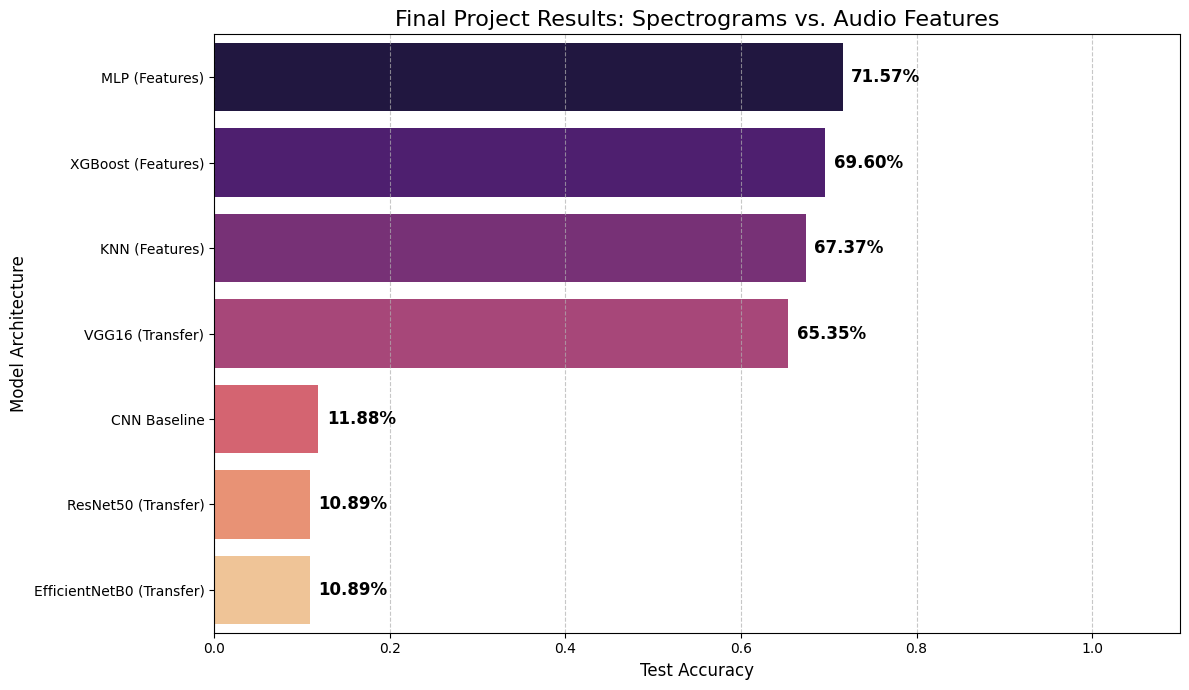


Final Leaderboard:
                    Model  Test Accuracy
           MLP (Features)       0.715716
       XGBoost (Features)       0.696044
           KNN (Features)       0.673674
         VGG16 (Transfer)       0.653465
             CNN Baseline       0.118812
      ResNet50 (Transfer)       0.108911
EfficientNetB0 (Transfer)       0.108911


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import tensorflow as tf

# Dictionary to store final results
model_scores = {}

print("--- Evaluating Part 1 Models (Spectrogram Images) ---")

# List of models and their SAVED FILENAMES
image_models = [
    ("CNN Baseline", "CNN_Spectrogram_best.keras"),
    ("VGG16 (Transfer)", "VGG16_Spectrogram_best.keras"),
    ("ResNet50 (Transfer)", "ResNet50_Spectrogram_best.keras"),
    ("EfficientNetB0 (Transfer)", "EfficientNetB0_Spectrogram_best.keras")
]

for label, filename in image_models:
    # Check if the file exists on the disk
    if os.path.exists(filename):
        print(f"Loading and Evaluating {label} from {filename}...")
        try:
            # Load the best saved version of the model
            loaded_model = tf.keras.models.load_model(filename)
            
            # Evaluate on the spectrogram test set
            loss, acc = loaded_model.evaluate(test_ds, verbose=0)
            model_scores[label] = acc
            print(f"   -> Accuracy: {acc:.2%}")
        except Exception as e:
            print(f"   Error loading {label}: {e}")
    else:
        print(f"File '{filename}' not found. Check if training cell ran successfully.")


print("\n---Evaluating Part 2 Models (Audio Features) ---")

# 1. KNN Evaluation (Variable Check)
if 'best_knn' in locals():
    print("Evaluating KNN...")
    # KNN uses the standard scaled test set
    acc = best_knn.score(X_test_scaled, y_test)
    model_scores["KNN (Features)"] = acc
    print(f"   -> Accuracy: {acc:.2%}")

# 2. MLP Evaluation (Variable Check)
if 'model_mlp' in locals():
    print("Evaluating MLP...")
    # MLP uses the standard scaled test set
    loss, acc = model_mlp.evaluate(X_test_scaled, y_test, verbose=0)
    model_scores["MLP (Features)"] = acc
    print(f"   -> Accuracy: {acc:.2%}")

# 3. XGBoost Evaluation (Only the clean version)
if 'xgb_model' in locals():
    print("Evaluating XGBoost...")
    # Try to use the CLEAN test set first (No Leakage)
    if 'X_test_clean' in locals():
        acc = xgb_model.score(X_test_clean, y_test_clean)
        model_scores["XGBoost (Features)"] = acc
        print(f"   -> Accuracy: {acc:.2%}")
    else:
        print("Clean test set not found. Skipping XGBoost.")

# --- Generate Comparison Chart ---

if model_scores:
    # Convert to DataFrame
    results_df = pd.DataFrame(list(model_scores.items()), columns=["Model", "Test Accuracy"])
    results_df = results_df.sort_values(by="Test Accuracy", ascending=False)

    # Plot
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(x="Test Accuracy", y="Model", data=results_df, palette="magma")
    
    # Formatting
    plt.title("Final Project Results: Spectrograms vs. Audio Features", fontsize=16)
    plt.xlabel("Test Accuracy", fontsize=12)
    plt.ylabel("Model Architecture", fontsize=12)
    plt.xlim(0, 1.1)  # Give space for labels
    
    # Add percentage labels
    for i, v in enumerate(results_df["Test Accuracy"]):
        ax.text(v + 0.01, i, f"{v:.2%}", va='center', fontweight='bold', fontsize=12)
        
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Print Table
    print("\nFinal Leaderboard:")
    print(results_df.to_string(index=False))
else:
    print("\nNo models found! Make sure you run the training cells above first.")

# DEMO

In [30]:
import librosa
import numpy as np
import os
import random
import IPython.display as ipd

In [31]:
# 1. Define the Feature Extractor
# This function replicates the exact math used to create 'features_3_sec.csv'
def extract_features_for_mlp(file_path):
    try:
        # Load audio (First 3 seconds only to match the training data)
        # We use sr=22050 because that is the GTZAN standard
        y, sr = librosa.load(file_path, duration=3.0, sr=22050)
        
        # --- Extract Features ---
        length = len(y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rms = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        harmony, perceptr = librosa.effects.hpss(y)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        
        # Handle tempo being an array in newer librosa versions
        if isinstance(tempo, np.ndarray):
            tempo = tempo[0]
            
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)

        # --- Organize into the exact order of the CSV columns ---
        # Order: Length, Chroma(m,v), RMS(m,v), Cent(m,v), BW(m,v), Rolloff(m,v), ZCR(m,v), Harm(m,v), Perc(m,v), Tempo, MFCCs...
        features = [length]
        
        for feat in [chroma_stft, rms, spec_cent, spec_bw, rolloff, zcr, harmony, perceptr]:
            features.append(np.mean(feat))
            features.append(np.var(feat))
            
        features.append(tempo)
        
        for i in range(20):
            features.append(np.mean(mfcc[i]))
            features.append(np.var(mfcc[i]))
            
        return np.array(features).reshape(1, -1)
        
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None

In [32]:
# 2. Select a File to Test
# Option A: Random file from the dataset
genre_dir = "./genres_original"
if os.path.exists(genre_dir):
    random_genre = random.choice(os.listdir(genre_dir))
    random_file = random.choice(os.listdir(os.path.join(genre_dir, random_genre)))
    test_audio_path = os.path.join(genre_dir, random_genre, random_file)
else:
    # Option B: Fallback manually set path
    test_audio_path = "/genres_original/disco/disco.00064.wav"
    
print(f"Selected Song: {test_audio_path}")
ipd.display(ipd.Audio(test_audio_path))

Selected Song: ./genres_original/disco/disco.00068.wav


In [33]:
# 3. Run Prediction
# Extract
raw_features = extract_features_for_mlp(test_audio_path)

if raw_features is not None:
    # Scale (Using the 'scaler' you fit during training)
    # Note: 'scaler' must represent the exact same scaling as the model saw
    scaled_features = scaler.transform(raw_features)
    
    # Pick the best model available
    if 'model_mlp' in locals():
        model_to_use = model_mlp
        print("Using Model: MLP (Original)")
    else:
        print("No MLP model found in memory!")
        model_to_use = None

    if model_to_use:
        # Predict
        pred_probs = model_to_use.predict(scaled_features)
        pred_idx = np.argmax(pred_probs)
        confidence = np.max(pred_probs)
        
        # Decode Label
        if 'le' in locals():
            pred_genre = le.inverse_transform([pred_idx])[0]
        else:
            # Manual fallback
            genres = sorted(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'])
            pred_genre = genres[pred_idx]
            
        print(f"\nPREDICTION: {pred_genre.upper()}")
        print(f"Confidence: {confidence:.2%}")

Using Model: MLP (Original)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

PREDICTION: DISCO
Confidence: 98.97%


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
